# Compute Human-Machine Alignment

This notebook computes the alignment between moves made by humans and the machine. To do so, we load the full trajectory of human moves, and predict for each move the best move according to the machine. The machine does so taking into account the trajectory of human play. We encode with one, if human and machine move matches.

In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# add dqn sub folder to python path
import sys
sys.path.append('dqn')

In [149]:
import pandas as pd
import os

import yaml
import json
import os

import torch as th
from dqn.environment_vect import Reward_Network
from dqn.dqn_agent import Agent
from dqn.config_type import Config

In [150]:
experiment_type = 'reward-network-iii-exp-v2'

moves_df = pd.read_csv(os.path.join('../data/exp_processed/moves.csv'))

networks_file = '../data/networks_solutions_models/solution_exp__valid_networks.json'

# Load the networks
with open(networks_file) as f:
    networks_exp = json.load(f)

config_file = '../algorithm/params/seed_0.yml'
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Config(**config)


In [151]:
moves_df['session_trial_id'] = moves_df['session_id'].astype(str) + '_' + moves_df['trial_id'].astype(str)

session_trial_id = moves_df['session_trial_id'].unique()
session_trial_idx = {session_trial_id[i]: i for i in range(len(session_trial_id))}

In [152]:
human_moves = th.full((len(session_trial_id), 10), -1, dtype=th.int64)
network_ids = []

for _, row in moves_df.iterrows():
    idx = session_trial_idx[row['session_trial_id']]
    human_moves[idx, row['move_idx']] = row['target_num']
    if row['move_idx'] == 0:
        network_ids.append(row['network_id'])

In [153]:
networks_keyed = {network['network_id']: network for network in networks_exp}
networks_reorganized = [networks_keyed[network_id] for network_id in network_ids]

In [154]:
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

all_ai_moves = []
for seed in range(3):

    env = Reward_Network(networks_reorganized, network_batch=None, config=config, device=DEVICE)
    AI_agent = Agent(
        observation_shape=env.observation_shape,
        config=config,
        action_dim=env.action_space_idx.shape,
        save_dir=None,
        device=DEVICE,
    )
    path = os.path.join('..',config.save_dir, f"{config.name}_{seed}.pt")
    AI_agent.load_model(path)

    # solve all networks at once in one go ("1 episode")
    ai_moves = AI_agent.solve_loop(
        episode=0,
        n_rounds=config.n_rounds,
        train_mode=False,
        exp_mode=True,
        env=env,
        logger=None,
        exec_actions=human_moves,
    )
    all_ai_moves.append(ai_moves)

/Users/brinkmann/repros/reward-network-iii/algorithm/dqn/environment_vect.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reward_map[prova_values] = torch.tensor(prova_keys, dtype=torch.long)


environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000])
environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000])
environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000])


In [159]:
moves_df['ai_target_num'] = None

for idx, row in moves_df.iterrows():
    session_idx = session_trial_idx[row['session_trial_id']]
    move_idx = row['move_idx']
    for seed in range(3):
        moves_df.at[idx, f'ai_target_num_{seed}'] = all_ai_moves[seed][session_idx, move_idx].item()


In [160]:
cols = ['ai_target_num_0', 'ai_target_num_1', 'ai_target_num_2']
moves_df['ai_target_num_same'] = moves_df[cols].nunique(axis=1) == 1
moves_df['ai_target_num'] = moves_df[cols].mode(axis=1)[0]

In [162]:
moves_df['human_machine_match'] = moves_df['ai_target_num'] == moves_df['target_num']
moves_df = moves_df.drop(columns=['ai_target_num'])

In [163]:
moves_df.to_csv(os.path.join('../data/exp_processed/moves_w_alignment.csv'), index=False)

/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
/Users/brinkmann/repros/reward-network-iii/.venv/lib/python3.13/site-packages/seaborn/relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
/Users/brinkmann

<Axes: xlabel='generation', ylabel='human_machine_match'>

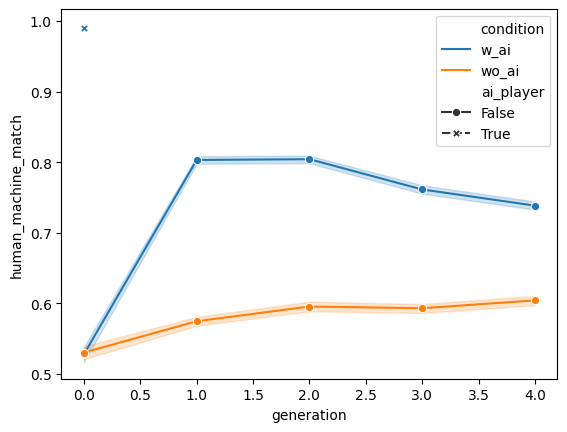

In [164]:
import seaborn as sns

df = moves_df[moves_df['trial_type'] == 'demonstration']

sns.lineplot(data=moves_df, x='generation', hue='condition', style='ai_player', y='human_machine_match', markers=True)
